# IS4861 Group Project - Seattle Airbnb Dataset

- Tim Löhr , EID: 40126684 
- Timo Bohnstedt, EID:
- Nicole , EID:
- Jenny , EID:
- Melanie, EID:

### We analysed the Kaggle dataset from Airbnb Seattle to deduce some customer behaviour and apply our information gain to do better marketing strategies and maximize the market value.

In [4]:
import pandas as pd
import numpy as np
from numpy import newaxis

import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import explained_variance_score, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM

import operator
import glob
import os, inspect
from IPython.display import Image
from zipfile import ZipFile
import tqdm

try:
    %tensorflow_version 2.x
    nltk.download('stopwords')
except Exception:
    pass

%matplotlib inline

# 1.0 Preprocessing of the Data
## 1.1 - Load the data into Panda Dateframes

In [2]:
path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) + "/seattle"

zf = ZipFile(str(path) + '.zip', 'r')
zf.extractall(path)

filenames = glob.glob(path + "/*.csv")

all_data = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

#reviews = data[0]
listings = all_data[1]
calendar = all_data[2]

calendar2 = calendar
listings2 = listings

print("Calendar: " +str(calendar.shape))
print("Listings: " +str(listings.shape))

dataset = pd.merge(listings, calendar, left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
#dataset = dataset[::6]
dataset = dataset.dropna(subset=['price_y'])

dataset.head()

Calendar: (1393570, 4)
Listings: (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,date,available,price_y
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-04,t,$85.00
1,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-05,t,$85.00
9,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-13,t,$85.00
10,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-14,t,$85.00
14,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-18,t,$85.00


## 1.2 - Feature selection and unique features

For selecting the features we first looked into the 92 possible features and decided which could make sense. For example a feature with the website link has no value for us. After applying this logical based filter we further tried to figure out with the unique values of each filter how much effort we need to put in to transform them from categorical into numerical values

In [3]:
# tags with the price -> full dataset
tags = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'bedrooms', 'bathrooms', 
        'beds', 'number_of_reviews','host_since', 'room_type', 'extra_people', 'host_identity_verified',
        'guests_included', 'cancellation_policy', 'require_guest_profile_picture', 'calculated_host_listings_count',
        'reviews_per_month', 'require_guest_phone_verification','price_y']

# Tags without the price_y to split into "X" and the price_y to "Y" datasets.
tags_x = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'bedrooms', 'bathrooms', 
        'beds', 'number_of_reviews','host_since', 'room_type', 'extra_people', 'host_identity_verified',
        'guests_included', 'cancellation_policy', 'require_guest_profile_picture', 'calculated_host_listings_count',
        'reviews_per_month', 'require_guest_phone_verification']

tags_x_new = ['bedrooms', 'beds', 'bathrooms', 'room_type', 'guests_included']

tags_new = ['bedrooms', 'beds', 'bathrooms', 'room_type', 'guests_included', 'price_y']

for col in tags:    
    if(col != 'reviews_per_month'):    
        idsUnique = len(set(dataset[col])) 
        idsTotal = dataset.shape[0] 
        idsDupli = idsTotal - idsUnique
        print("There are %5d unique '%35s' with datatype %10s" % (idsUnique, col, dataset[col].dtype))
print()
print("------------------------")
print("For %d total entries" % idsTotal )

There are     5 unique '                 host_response_time' with datatype     object
There are    46 unique '                 host_response_rate' with datatype     object
There are     3 unique '               host_acceptance_rate' with datatype     object
There are  2011 unique '                           bedrooms' with datatype    float64
There are  4815 unique '                          bathrooms' with datatype    float64
There are   376 unique '                               beds' with datatype    float64
There are   195 unique '                  number_of_reviews' with datatype      int64
There are  1366 unique '                         host_since' with datatype     object
There are     3 unique '                          room_type' with datatype     object
There are    45 unique '                       extra_people' with datatype     object
There are     3 unique '             host_identity_verified' with datatype     object
There are    15 unique '                    guests_inc

#### The next cell fills up all the missing values with default values and transform the categorical into numerical values. 
We end up with 2 datasets:
- dataset_int
- dataset_float

The Integer dataset is for the analysis and the float dataset for feeding the neural network

In [16]:
# Fill the rows with missing values up with default values to be able to calculate
dataset.loc[:, "host_response_time"] = dataset.loc[:, "host_response_time"].fillna(0)
dataset.loc[:, "require_guest_phone_verification"] = dataset.loc[:, "require_guest_phone_verification"].fillna('f')
dataset.loc[:, "host_response_rate"] = dataset.loc[:, "host_response_rate"].fillna(0)
dataset.loc[:, "host_acceptance_rate"] = dataset.loc[:, "host_acceptance_rate"].fillna(0)
dataset.loc[:, "reviews_per_month"] = dataset.loc[:, "reviews_per_month"].fillna(0)
dataset.loc[:, "calculated_host_listings_count"] = dataset.loc[:, "calculated_host_listings_count"].fillna(0)
dataset.loc[:, "require_guest_profile_picture"] = dataset.loc[:, "require_guest_profile_picture"].fillna('f')
dataset.loc[:, "cancellation_policy"] = dataset.loc[:, "cancellation_policy"].fillna('moderate')
dataset.loc[:, "bathrooms"] = dataset.loc[:, "bathrooms"].fillna(0)
dataset.loc[:, "bedrooms"] = dataset.loc[:, "bedrooms"].fillna(0)
dataset.loc[:, "beds"] = dataset.loc[:, "beds"].fillna(0)
dataset.loc[:, "number_of_reviews"] = dataset.loc[:, "number_of_reviews"].fillna(0)
dataset.loc[:, "host_since"] = dataset.loc[:, "host_since"].fillna(2018)
dataset.loc[:, "room_type"] = dataset.loc[:, "room_type"].fillna('Private room')
dataset.loc[:, "extra_people"] = dataset.loc[:, "extra_people"].fillna(0)
dataset.loc[:, "host_identity_verified"] = dataset.loc[:, "host_identity_verified"].fillna('f')
dataset.loc[:, "guests_included"] = dataset.loc[:, "guests_included"].fillna(0)

dataset['host_response_rate'] = [rate.replace('%', '') for rate in dataset['host_response_rate'].astype(str)]
dataset['bedrooms'] = dataset['bedrooms'].astype('int32')
dataset['bathrooms'] = dataset['bathrooms'].astype('int32')
dataset['beds'] = dataset['beds'].astype('int32')
dataset['host_since'] = [host[:4] for host in dataset['host_since'].astype(str)]
dataset['extra_people'] = [extra[:-3].replace('$', '') for extra in dataset['extra_people'].astype(str)]
dataset['price_y'] = [price[:-3].replace('$', '').replace(',', '') for price in dataset['price_y'].astype(str)]

# Replace categorical with numerical values to be able to fit the models
dataset = dataset.replace({"host_response_time" : {np.isnan : 0, 'a few days or more' : 1, 'within a day' : 2, 
                                                   'within a few hours' : 3, 'within an hour': 4},
                          "host_acceptance_rate" : {'0%': 0, '100%': 1},
                           "room_type" : {'Entire home/apt': 3, 'Private room': 2, 'Shared room' : 1},
                           "host_identity_verified" : {"f" : 0, "t" : 1},
                           "cancellation_policy" : {'flexible': 3, 'moderate': 2, 'strict': 1},
                           "require_guest_profile_picture" : {'f': 0, 't': 1},
                           "require_guest_phone_verification" : {'f': 0, 't': 1}
                          })

dataset_int = dataset[tags].astype('int32')
dataset_float = dataset[tags].astype(float)

# 2.0 Dataset close-up
## 2.1 - A closer look into the "Listings" dataset 

In [17]:
nb = listings[['review_scores_value', 'neighbourhood']].dropna()
X = np.array(nb['neighbourhood'])
y = np.array(nb['review_scores_value'].astype(int))
label = nb['review_scores_value'].astype(int)

# Apply the scores to the unique citys
rating = dict()

for r, nb in zip(y, X):
    if(nb not in rating):
        rating[nb] = [r, 1]
    else:
        rating[nb][0] += r
        rating[nb][1] += 1
        
print("X: Neighbourhood: " + str(X.shape))
print("Y: Score for the accommodation: " +str(y.shape))
print("Unique Neighbourhoods: " + str(len(set(X))))

X: Neighbourhood: (2858,)
Y: Score for the accommodation: (2858,)
Unique Neighbourhoods: 79


#### The Price range and the mean

In [6]:
min_price = dataset_int['price_y'].min()
max_price = dataset_int['price_y'].max()
mean_price = dataset_int['price_y'].mean()

print('Minimum price is ' + str(min_price) +'$')
print('Maximum price is ' + str(max_price) +'$')
print('Average price is ' + str(round(mean_price, 2)) +'$')

Minimum price is 10$
Maximum price is 1650$
Average price is 137.94$


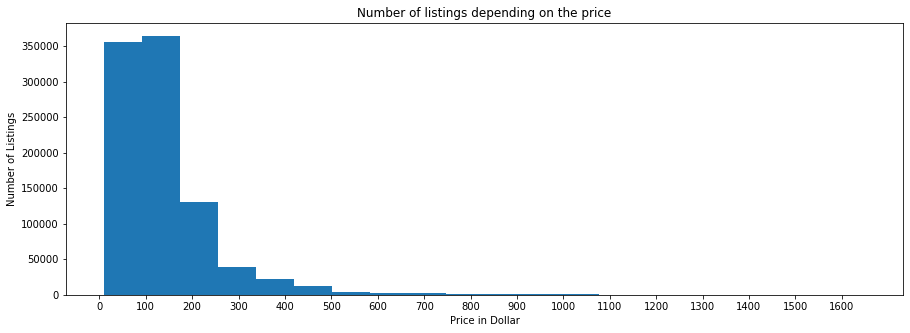

In [7]:
mean_price = dataset_int.groupby(dataset_int.index).mean()['price_y']

plt.figure(figsize=(15,5))
plt.hist(mean_price, bins=20)
plt.xticks(np.arange(0, max_price, step=100))
plt.ylabel('Number of Listings')
plt.xlabel('Price in Dollar')
plt.title('Number of listings depending on the price')
plt.show()

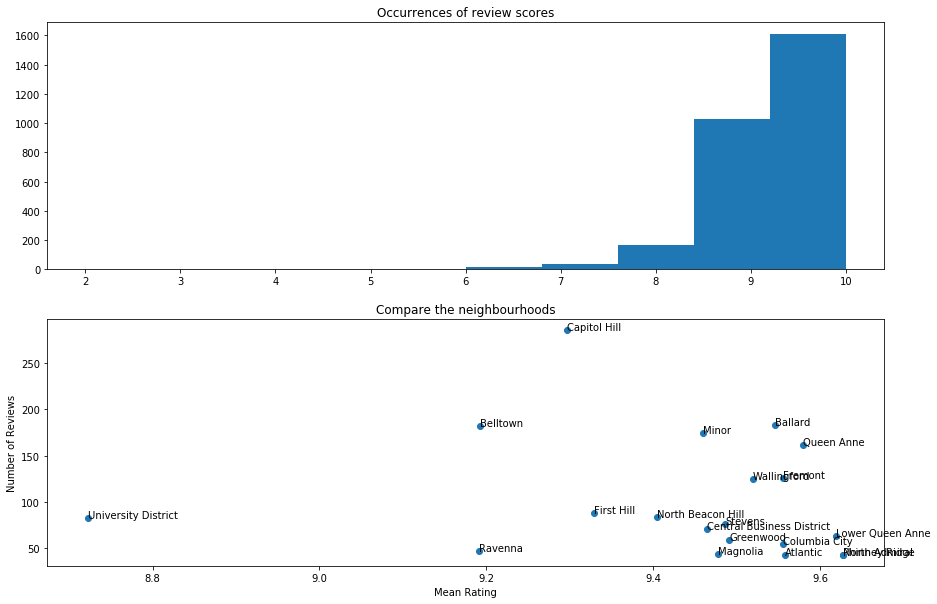

In [8]:
# Sort, Sum and ocunt the ratings of all the citys

x = sorted(rating.items(), key=lambda x: x[1])[::-1][:20]
names = [x[0] for x in x]
x_sum = [x[1][0] for x in x]
y_count = [x[1][1] for x in x]
x_mean = []

for x, y in zip(x_sum, y_count):
    x_mean.append(x/y)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    
ax1.hist(label)
ax1.set_title("Occurrences of review scores")

for i, name in enumerate(names):
    ax2.annotate(name, (x_mean[i], y_count[i]))

ax2.scatter(x_mean, y_count)
ax2.set_title("Compare the neighbourhoods")
ax2.set_ylabel("Number of Reviews")
ax2.set_xlabel("Mean Rating")
plt.show()

#### Amount of accommodations in each district

In [9]:
neighbourhoods = Counter(listings['neighbourhood'].dropna())

sorted_neighbourhoods = sorted(neighbourhoods.items(), key=operator.itemgetter(1))[::-1]
hoods = []

for i in range(0, 10):
    hoods.append(sorted_neighbourhoods[i][0])

In [8]:
combined = listings[['room_type', 'neighbourhood']].dropna()

hood_type = {x: [0, 0, 0] for x in set(combined['neighbourhood'])}

room_types = {'Private room':0, 'Entire home/apt':1, 'Shared room':2}


for room, nh in zip(combined['room_type'], combined['neighbourhood']):
        hood_type[nh][room_types[room]] += 1

for hood in hoods:
    print("{:20s} has   Private: {:2d}, Home/Apt: {:3d}, Shared: {:2d} and total of {:3d}"
          .format(hood, hood_type[hood][0], hood_type[hood][1], hood_type[hood][2], sum(hood_type[hood])))

Capitol Hill         has   Private: 84, Home/Apt: 245, Shared: 22 and total of 351
Ballard              has   Private: 75, Home/Apt: 138, Shared:  0 and total of 213
Belltown             has   Private:  9, Home/Apt: 192, Shared:  3 and total of 204
Minor                has   Private: 72, Home/Apt: 116, Shared:  4 and total of 192
Queen Anne           has   Private: 43, Home/Apt: 143, Shared:  1 and total of 187
Fremont              has   Private: 40, Home/Apt: 105, Shared:  3 and total of 148
Wallingford          has   Private: 34, Home/Apt:  97, Shared: 12 and total of 143
University District  has   Private: 26, Home/Apt:  72, Shared:  9 and total of 107
First Hill           has   Private: 12, Home/Apt:  88, Shared:  5 and total of 105
Stevens              has   Private: 34, Home/Apt:  50, Shared: 14 and total of  98


### Bar Chart for top 10 accommodations split by room/type

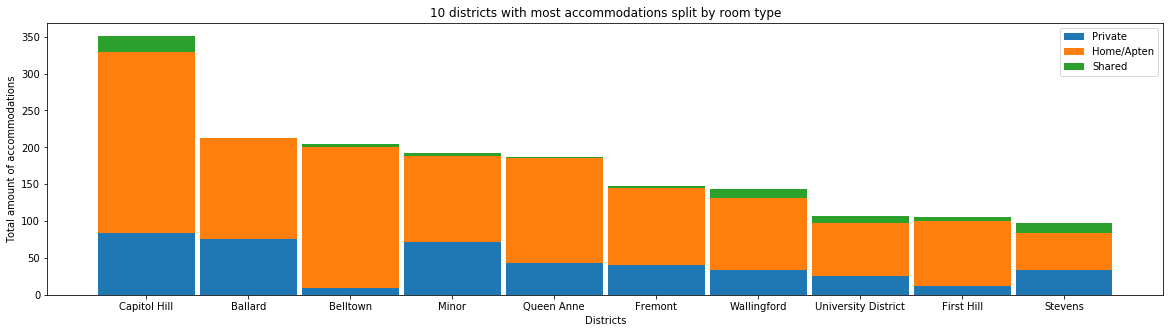

In [94]:
y_pos = np.arange(len(hoods))
width = 0.95

plt.figure(figsize=(20,5))

p1 = plt.bar(y_pos, histo[0], width)
p2 = plt.bar(y_pos, histo[1], width, bottom=histo[0])
p3 = plt.bar(y_pos, histo[2], width, bottom=histo[1] + histo[0])

plt.title('10 districts with most accommodations split by room type')
plt.xticks(y_pos, hoods)
plt.xlabel("Districts")
plt.ylabel("Total amount of accommodations")
plt.legend((p1[0], p2[0], p3[0]), ('Private', 'Home/Apten', 'Shared'))
plt.show()

## 2.2 - A closer look into the "Calendar" dataset 
The next code block shows the daily activity of 2016 to get first impressions of how many customers sleep daily in a Airbnb accommodation

#### We first want to find out the monthly visitors for the year 2016 to get some insights about the numbers

In [7]:
calendar = calendar.dropna()
dates = calendar['date']
price = calendar['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

for i, month in enumerate(monthly_visitors):
    print("Monthly visitors for {:10s} : {:10d}".format( months[i], month))
print(44*"-")
print("Mean monthly visitors for 2016  :      " + str(int(np.mean(monthly_visitors))))

Monthly visitors for January    :      64937
Monthly visitors for February   :      73321
Monthly visitors for March      :      83938
Monthly visitors for April      :      76037
Monthly visitors for May        :      79971
Monthly visitors for June       :      77244
Monthly visitors for July       :      74222
Monthly visitors for August     :      76347
Monthly visitors for September  :      77246
Monthly visitors for October    :      82438
Monthly visitors for November   :      81780
Monthly visitors for December   :      87061
--------------------------------------------
Mean monthly visitors for 2016  :      77878


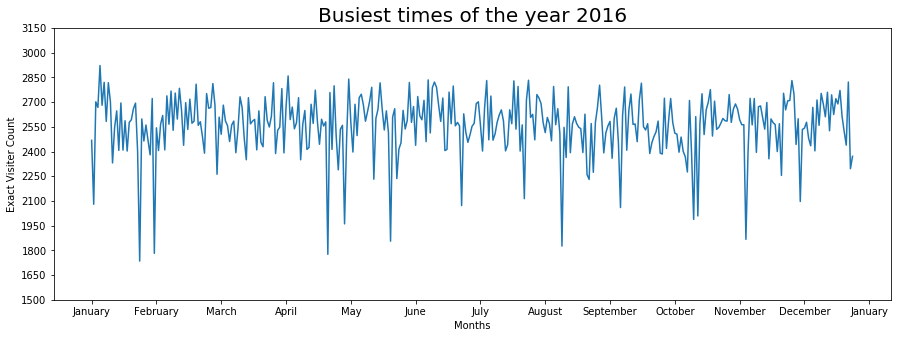

In [8]:
year_num = []

# Iterate over all entries and append the single counts of customers
for i, date in enumerate(year_date.items()):
    year_num.append(date[1])

plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(year_num) + 1), year_num)
plt.title("Busiest times of the year 2016", fontsize=20)
plt.xlabel("Months")
plt.ylabel("Exact Visiter Count")
plt.yticks(np.arange(1500, 3250, 150))
plt.xticks(np.arange(1, 395, 31), months)
plt.show()

#### Now we perform a 5 degree Ridge Regression to estimate the amount of people coming in the year 2017

With this knowledge we are trying to find out whether it is lucrative to possibly provide even more Airbnb flats if the market shows a tendency to rise up

5 degree Polynomial Ridge Regression
Coefficients and Intercept of the Linear Regression: 

Y = [0.0, 2192.97, 3031.84, -999.74, 104.61, -3.54]X + 63243.54


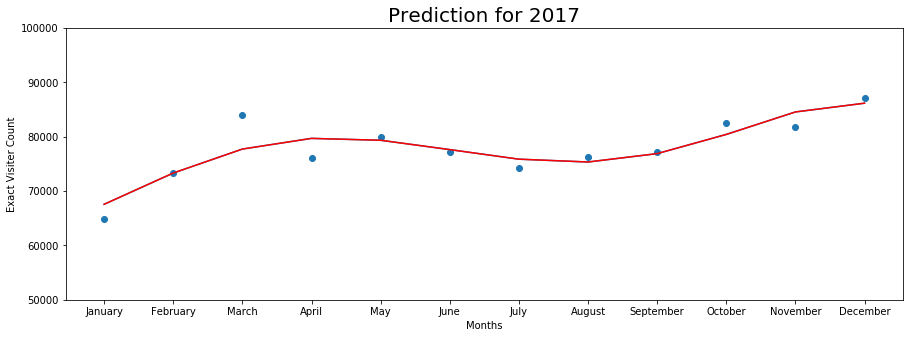

In [9]:
y = np.array(monthly_visitors)
X = np.array(np.arange(1, 13))

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X[:, np.newaxis]
y = y[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)

# Fit the Linear Regression
rr = linear_model.Ridge()
rr.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = rr.predict(x_poly)

print("5 degree Polynomial Ridge Regression")
print("Coefficients and Intercept of the Linear Regression: \n")
print("Y = " + str([round(x,2) for x in rr.coef_[0]]) + "X + "+ str(round(rr.intercept_[0], 2)))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(np.arange(1, len(y_poly_pred) + 1), y_poly_pred)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months")
plt.ylabel("Exact Visiter Count")
plt.yticks(np.arange(50000, 110000, 10000))
plt.xticks(np.arange(1, 13), months)
plt.show()

# 3.0 - Model Analysis
## 3.1 - Feature Importance
We chose the Extra Tree Classifier over the Random Forest, because in the scikit learn implementation it is much faster and outputs similar results

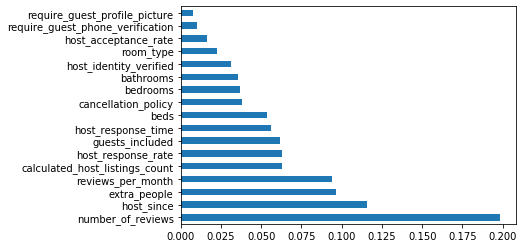

In [12]:
model = ExtraTreesClassifier(n_estimators=100)
model.fit(dataset_int[tags_x], dataset_int.price_y)
#print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=dataset_int[tags_x].columns)
feat_importances.nlargest(dataset_int[tags_x].shape[1]).plot(kind='barh')
plt.show()

### To see which features correlate which each other and especially with the price_y for further predictions in section 4 we constructed the heatmap for the selected features

##### As we can see the 

- bedrooms
- beds
- bathrooms
- room-type
- guests-included

have high influence on the price_y

#### but

- host_reponse_time
- host_response_rate
- host_acceptance_rate

#### correlate with each other

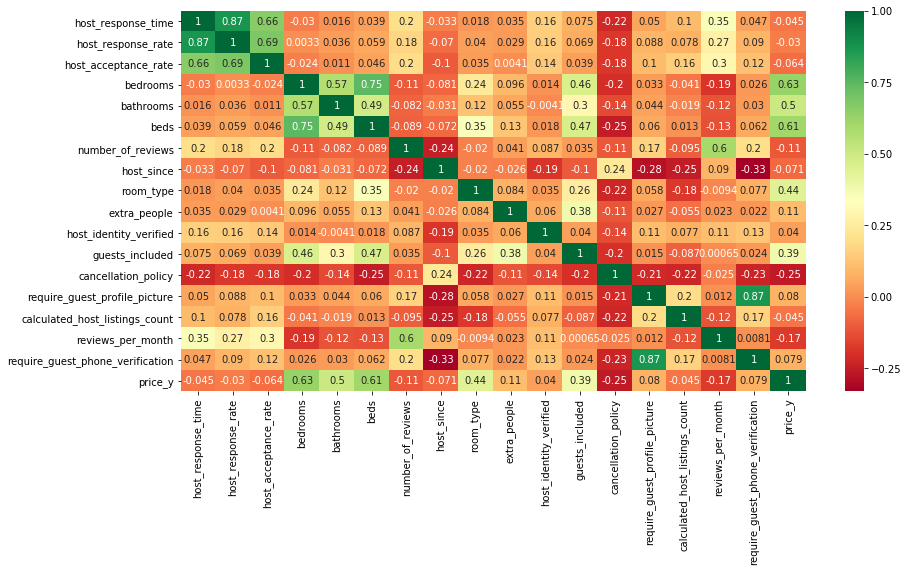

In [13]:
plt.figure(figsize=(14,7))
g=sns.heatmap(dataset_int[tags].corr(), annot=True, cmap="RdYlGn")

## 3.1 - Correlation of features
#### Correlation of Bathrooms and price_y

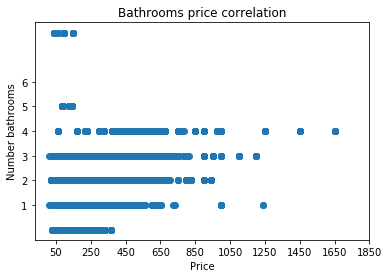

In [14]:
# Sort by the amount of bedrooms to plot it correctly
sorted_x = pd.DataFrame([dataset_int['bathrooms'], dataset_int.price_y]).T
sorted_x = sorted_x.sort_values(by=['price_y'])

plt.scatter(sorted_x.price_y, sorted_x.bathrooms)
plt.title("Bathrooms price correlation")
plt.ylabel("Number bathrooms")
plt.xlabel("Price")
plt.xticks(np.arange(50, 2000, 200))
plt.yticks(np.arange(1, len(set(sorted_x.bathrooms))))
plt.show()

#### Correlation of Bedrooms and price_y

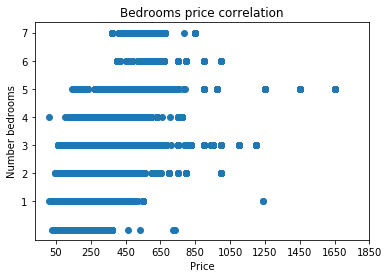

In [15]:
# Sort by the amount of bedrooms to plot it correctly
sorted_x = pd.DataFrame([dataset_int['bedrooms'], dataset_int.price_y]).T
sorted_x = sorted_x.sort_values(by=['price_y'])

plt.scatter(sorted_x.price_y, sorted_x.bedrooms)
plt.title("Bedrooms price correlation")
plt.ylabel("Number bedrooms")
plt.xlabel("Price")
plt.xticks(np.arange(50, 2000, 200))
plt.yticks(np.arange(1, len(set(sorted_x.bedrooms))))
plt.show()

## 3.2 - Wordcloud
Through a Wordcloud it is possible to visualize which words are most commonly used in the reviews. Further analysis in form of a "Sentiment Analysis" could be performed, but it is rather useless based on the knowledge we already have gained from the graph at 2.1) 
- Occurrences of review scores  
- Compare the neighborhoods

We can see in those two graphs that most of the reviews are positive, so we can deduce that the sentiment of the reviews is positive

In [16]:
data = dict()
# Stem the words to their origin:  played -> play
stemmer = SnowballStemmer("english")

# combine review with city name together in data array
for nh, overview in zip(listings['neighbourhood'].dropna().astype(str), listings['neighborhood_overview'].astype(str)):
    if(nh in data):
        data[nh] += overview
    else:
        data[nh] = overview

nb_vibe = {}
nb_freq = {} 
 
# Natural Language Processing Preprocessing for all the reviews
for nh in data:
    t = RegexpTokenizer(r'\w+')     # Get rid of .,?!"" and additional spaces
    tokens = t.tokenize(data[nh])   # Tokenize a sentence and splits it by a space
    
    stop_words = set(stopwords.words('english'))   # Remove Stopwords aka "and" or "with"
    stop_words2 = [*nh.lower().split(' '), 'seattle', 'neighborhood']   # lower the caps of the words
    
    # Apply all of that
    tokens = [w.lower() for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w in stop_words2]
    tokens = [stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    
    # Calculate the frequency count of the words
    frequency_dist = nltk.FreqDist(tokens)
    nb_freq[nh] = frequency_dist
    
    # I store the 50 most used words in the nb_vibe array
    nb_vibe[nh] = sorted(frequency_dist, key=frequency_dist.__getitem__, reverse=True)[0:50]

#### For simplicity we only show the Wordclouds of the 6 cities with the most reviews

In [17]:
# Use the 6 citys with the most reviews to apply the 50 most frequent words on
max_words = {}
for nh in nb_vibe:
    max_words[nh] = len(data[nh])
    
top_reviewed_citys = sorted(max_words, key=max_words.get)[::-1][:6]

for i, city in enumerate(top_reviewed_citys):
    print(str(i + 1) + ". with " + str(max_words[city]) + " reviews is " + str(city) )

1. with 106227 reviews is Capitol Hill
2. with 66224 reviews is Ballard
3. with 60147 reviews is Queen Anne
4. with 50645 reviews is Belltown
5. with 50305 reviews is Minor
6. with 49227 reviews is Wallingford


#### The Wordclouds for those 6 most reviewed cities

As one can see, the verbs and the adjective are missing some letters. This is due of the stemming and lemmitization process. We don't want to have certain words in different shapes in one cloud grouped together. 
We would end up with 
- walking 
- walked 
- walk 

in one cloud. To avoid that we undertook the reviews the NLP preprocessing

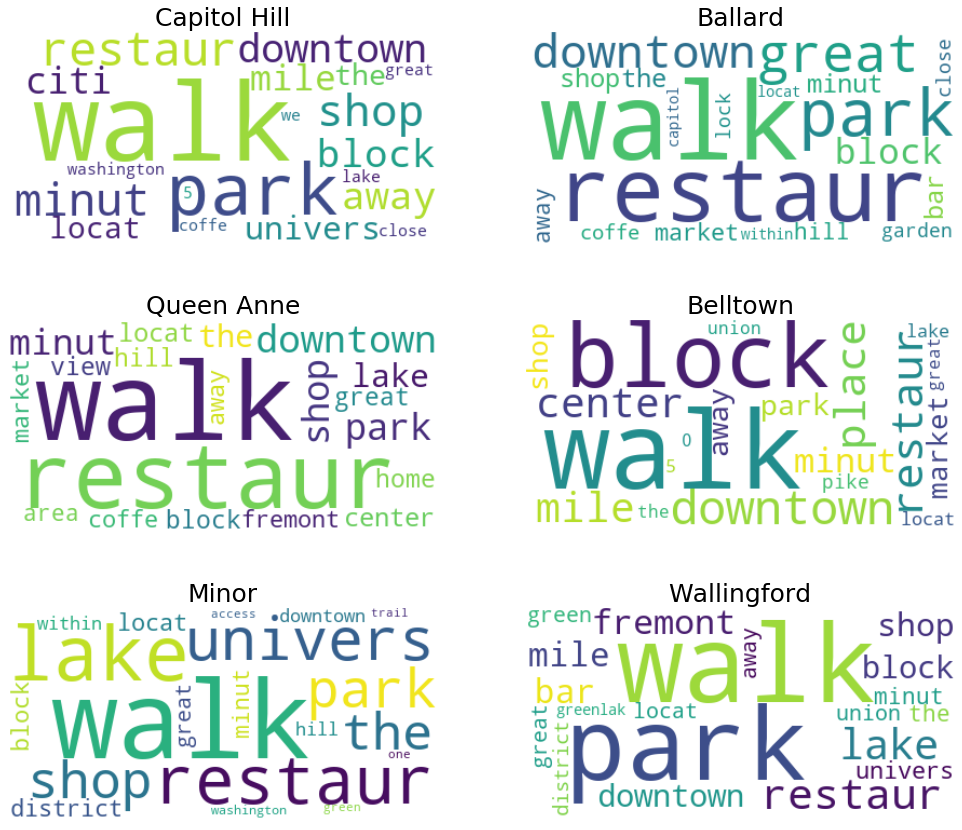

In [18]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(17,15))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax, city in zip(axs, top_reviewed_citys):
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=20, background_color="white").generate_from_frequencies(nb_freq[city])
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(city, fontsize=25)

## 3.3 - Occupation ratio of the Airbnb accommodations

Since it was hard figure out when a flat is really occupied by a costumer or when a flat is just currently not available, because the owner doesn't want people to live in at the moment, i assume that a free flat counts as no visitor and a occupied flat counts as a costumer is living in the flat.

For this ratio between empty and occupied we did all the below calculations

In [19]:
# Create a new DataFrame
new_listings = listings2[['id', 'beds', 'availability_30', 'availability_365']] 

# Merge the Calendar and Listings DataFrame with neccessaty columns
availability = pd.merge(new_listings, calendar2, left_on='id', right_on='listing_id', 
                        how='left').drop('listing_id', axis=1)
# Little preprocessing
availability = availability.replace({"available" : {"t": 1, "f": 0}}).drop('price', 1)

# Devide and group by the free = 1 and occupied = 0 flats.
daily_available = availability.groupby([availability.date, availability.available]).count()
daily_available = np.array(daily_available['id'])

# Total Count of free and occupied days
daily_free = daily_available[::2]
daily_occupied = daily_available[1::2]

# Ratios of free and occupied days
daily_free_rate = (daily_free / (daily_free + daily_occupied))
daily_occupied_rate = (daily_occupied / (daily_free + daily_occupied))

#### Since I use the ratio, the y axis at 1 signals the 100%. We can observe, that in January there is more or less half of all flats available, whereas there are 3 main intervalls over the year. 

Most people visit Seattle in April, end of June and Christmas.

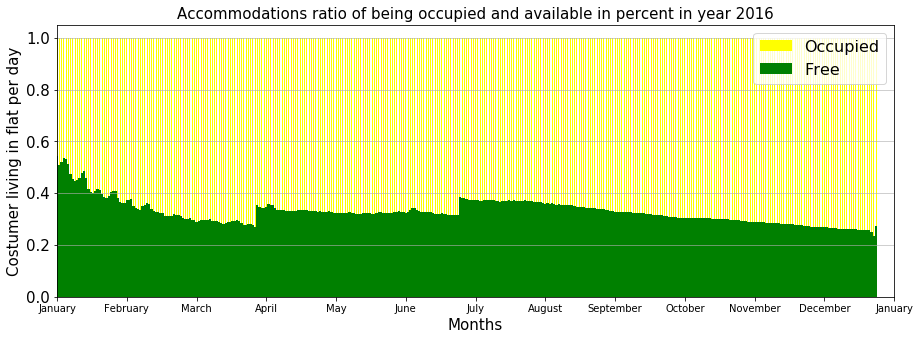

In [20]:
plt.figure(figsize=[15,5])
plt.bar(np.arange(1,366), daily_occupied_rate + daily_free_rate, width = 0.5, color='yellow',alpha=1, label="Occupied")
plt.bar(np.arange(1,366), daily_free_rate, width = 1, color='green',alpha=1, label="Free")
plt.xlim(min(np.arange(1,366)), max(np.arange(1,366)))
plt.grid(axis='y', alpha=0.75)
plt.legend(['Occupied', 'Free'], prop={'size': 16})
plt.xlabel('Months',fontsize=15)
plt.ylabel('Total Capacity',fontsize=15)
plt.xticks(np.arange(1, 395, 31), months)
plt.yticks(fontsize=15)
plt.ylabel('Costumer living in flat per day',fontsize=15)
plt.title('Accommodations ratio of being occupied and available in percent in year 2016',fontsize=15)
plt.show()

## 3.4 - Price fluctuation over the years
#### Fluctuation for the year 2016

We can observe, that eventhough in christmas there is a peak of costumers, the price is rather low.
Whereas in the June and July sommer vacation time, in which also a lot of people arrive, we have the highest price. 

The flat owners apparently try to make the most money out of the flats in the summer time

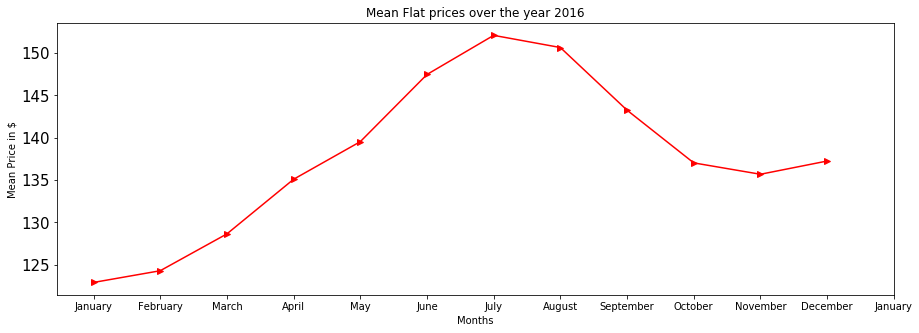

In [21]:
# Preprocessing for the mean calculation. More complicated programmed then neccessary.
occupy_rate = pd.DataFrame()
occupy_rate = availability.groupby([availability.date]).count()
occupy_rate['rate'] = daily_occupied_rate
most_visited_days = occupy_rate.sort_values('rate')[::-1][:30]

# Assign new DataFrame
date_price = calendar
date_price = date_price[['date', 'price']].dropna(0)

date_price['price'] = [x.replace('$', '')[:-3] for x in date_price['price']]
date_price = date_price.sort_values(['date', 'price'])

x = np.array(date_price['date'])
y = np.array(date_price['price'])

x_set = np.array([x for x in set(x)])
x_set.shape

monthly_mean = {x: [] for x in np.arange(1,13)}

# Split date '2016-01-04' into ['2016', '01', '04'] to select by month
for date, price in zip(x, y):
    month = int(date.split('-')[1])
    price = price.replace(',', '')
    price = int(price)
    monthly_mean[month].append(price)

mean_prices = {x: 0 for x in np.arange(1,13)}

# Append all entries to a new array to calculate mean
for month in monthly_mean.items():
    value = 0
    for number in month[1]:
        value += int(number)
    value /= len(month[1])
    mean_prices[month[0]] = value
    
# Calculate the mean
mean_price = []
for price in mean_prices.items():
    mean_price.append(price[1])
    
plt.figure(figsize=[15,5])
plt.title("Mean Flat prices over the year 2016")
plt.plot(np.arange(1, 13), mean_price, 'r->')
plt.ylabel("Mean Price in $")
plt.xlabel("Months")
plt.xticks(np.arange(1, 14), months)
plt.yticks(fontsize=15)
plt.show()

# 4.0 - Price Prediction
## 4.1 - Linear Regression
#### Splitting the dataset first

In [18]:
# Split the data into Train 66% and Test 33%

X_train, X_test, y_train, y_test = train_test_split(dataset_int[tags_x], dataset_int.price_y, test_size=0.33, random_state=42)

print("X Train data shape: " +str(X_train.shape))
print("y Train data shape: " + str(y_train.shape))
print("X Test data shape: " + str(X_test.shape))
print("y Train data shape: " + str(y_test.shape))

X Train data shape: (626143, 17)
y Train data shape: (626143,)
X Test data shape: (308399, 17)
y Train data shape: (308399,)


In [19]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print("Mean absolute Error : {:9.2f}".format(round(mae, 2)))
print("Mean squared Error  : {:9.2f} \n".format(round(mse, 2)))

exp_var = round(explained_variance_score(y_test, y_pred),2)
r2 = round(r2_score(y_test, y_pred),2)

print("Explained Variance: " + str(exp_var))
print("R2 Score: " + str(round(r2,2)))

Mean absolute Error :     43.89
Mean squared Error  :   4931.74 

Explained Variance: 0.55
R2 Score: 0.55


## 4.2 - Elastic Net CV

In [20]:
regr = linear_model.ElasticNetCV(cv=5, random_state=42, n_jobs=4, verbose=1, precompute=True)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print("Mean absolute Error : {:9.2f}".format(round(mae, 2)))
print("Mean squared Error  : {:9.2f} \n".format(round(mse, 2)))

exp_var = round(explained_variance_score(y_test, y_pred),2)
r2 = round(r2_score(y_test, y_pred),2)

print("Explained Variance: " + str(exp_var))
print("R2 Score: " + str(round(r2,2)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


Mean absolute Error :     46.05
Mean squared Error  :   5458.21 

Explained Variance: 0.5
R2 Score: 0.5


## 4.3 - Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
clf = BernoulliNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print("Mean absolute Error : {:9.2f}".format(round(mae, 2)))
print("Mean squared Error  : {:9.2f} \n".format(round(mse, 2)))

Mean absolute Error :     91.83
Mean squared Error  :  22860.03 



## 4.4 - LSTM Neuronal Network
To fit the data into the Neural Network, we need to create a new dimension, because the LSTM model
expect format like (17, 1), since our data is 104365 and 17 features, we need to reshape it to (104365, 17, 1)
and cut away the first dimension when we give it as parameter to the neural net -> (17, 1)

In [24]:
Xtrain = np.array(X_train)

# Scale the values between [-1 , 1] to eliminate too big values
scaler = MinMaxScaler()
trainXn = scaler.fit_transform(Xtrain)

# shape [X, 17, 1]
trainXs = trainXn[:,:, newaxis]

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=trainXs.shape[-2:]))  
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01), loss='mae')
model.fit(trainXs, y_train, epochs=10, batch_size=2048)

Epoch 1/10
626143/626143 [==============================] - 256s 408us/step - loss: 93.2414
Epoch 2/10
626143/626143 [==============================] - 245s 391us/step - loss: 64.9532
Epoch 3/10
626143/626143 [==============================] - 244s 390us/step - loss: 64.0659
Epoch 4/10
626143/626143 [==============================] - 243s 388us/step - loss: 64.0510
Epoch 5/10
626143/626143 [==============================] - 241s 385us/step - loss: 64.0460
Epoch 6/10
626143/626143 [==============================] - 241s 385us/step - loss: 64.0436
Epoch 7/10
626143/626143 [==============================] - 239s 381us/step - loss: 64.0432
Epoch 8/10
626143/626143 [==============================] - 238s 380us/step - loss: 64.0431
Epoch 9/10
626143/626143 [==============================] - 266s 424us/step - loss: 64.0433
Epoch 10/10
626143/626143 [==============================] - 259s 414us/step - loss: 64.0432
